# Notebook communauté

Ce notebook interactif permet de consulter l'API beta.gouv.fr et toutes les données publiques de la communauté

Vous pouvez modifier et rejouter chaque cellule indépendamment. 👉 [Guide rapide pour utiliser un notebook](https://pyspc.readthedocs.io/fr/latest/03-guide/#comment-utiliser-un-fichier-notebook)

In [113]:
import requests
import pandas
import json
import urllib.parse
from datetime import datetime
from matplotlib import pyplot
from IPython.display import display_markdown

pandas.set_option("display.max_colwidth", None)

phases = [
    "investigation",
    "construction",
    "acceleration",
    "transfer",
    "success",
    "alumni",
]
colors = ["#ffd17a", "#ff914d", "#fa6bbc", "#0bffb3", "#1fbcff", "#aaa"]

def flatmap(arr):
  arr2=[]
  for i in arr:
    if i in arr2:
      continue
    arr2.append(i)
  return arr2

In [21]:
startups_details = [
    data
    for (key, data) in requests.get(
        "https://beta.gouv.fr/api/v2.6/startups_details.json"
    )
    .json()
    .items()
]
startups = [
    {"id": item.get("id"), **item.get("attributes"), **item.get("relationships")}
    for item in requests.get(
        "https://beta.gouv.fr/api/v2.6/startups.json"
    )
    .json()
    .get("data")
]
authors = requests.get("https://beta.gouv.fr/api/v2.6/authors.json").json()

In [22]:
print(f"Loaded {len(startups_details)} startups_details")
print(f"Loaded {len(startups)} startups")
print(f"Loaded {len(authors)} authors")

Loaded 519 startups_details
Loaded 519 startups
Loaded 2701 authors


In [23]:
# Cleanup some data
startups_df = pandas.DataFrame.from_dict(startups)


def phase_date_getter(phase):
    return datetime.fromisoformat(phase.get("start"))


#startups_df["stats_url"] = startups_df["stats_url"].fillna("")

startups_df["markdown"] = startups_df["content_url_encoded_markdown"].map(
    urllib.parse.unquote
)
startups_df = startups_df.drop(columns=["content_url_encoded_markdown"])

startups_df["phase"] = startups_df["phases"].apply(
    lambda x: sorted(x, key=phase_date_getter, reverse=True)[0].get("name")
)

startups_df["incubator"] = startups_df["incubator"].apply(
    lambda x: x.get("data", {}).get("id")
)

In [24]:
display_markdown(
    "## Aperçu des données",
    raw=True,
)

startups_df[["id", "name", "incubator", "phase", "contact", "stats_url"]].head(10)

## Aperçu des données

,id,name,incubator,phase,contact,stats_url
0,1-jeune-1-arbre,1 Jeune 1 Arbre,agriculture,investigation,melanie.briand@beta.gouv.fr,
1,1000.jours,1000 premiers jours - l'app,sgmas,transfer,love.andrieu@social.gouv.fr,https://1000jours.fabrique.social.gouv.fr/stats
2,1000.premiers.jours.blues,1000 premiers jours Blues,sgmas,acceleration,contact-nos1000jours@fabrique.social.gouv.fr,https://1000jours-blues.fabrique.social.gouv.fr/stats
3,a-dock,A Dock,mtes,alumni,contact@adock.beta.gouv.fr,https://adock.beta.gouv.fr/stats
4,a-just,A-JUST,justice,acceleration,contact@a-just.fr,https://a-just.beta.gouv.fr/stats
5,acces.majeur.protege,Accès Majeur Protégé,justice,alumni,anne.devoret@beta.gouv.fr,
6,acceslibre,Acceslibre,mtes,acceleration,acceslibre@beta.gouv.fr,https://acceslibre.beta.gouv.fr/stats
7,accesscite,Access'cité,mtes,construction,melanie.briand@beta.gouv.fr,
8,accueil-telephonique-uts,Accueil UTS,anct,alumni,contactincubateur@anct.gouv.fr,
9,aeris,Aeris,mtes,alumni,jacob.carbonel@beta.gouv.fr,


In [25]:
startups_df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    519 non-null    object
 1   name                  519 non-null    object
 2   pitch                 519 non-null    object
 3   stats_url             519 non-null    object
 4   contact               519 non-null    object
 5   events                519 non-null    object
 6   phases                519 non-null    object
 7   sponsors              519 non-null    object
 8   thematiques           519 non-null    object
 9   incubator             519 non-null    object
 10  link                  228 non-null    object
 11  repository            215 non-null    object
 12  dashlord_url          86 non-null     object
 13  accessibility_status  244 non-null    object
 14  analyse_risques       24 non-null     object
 15  budget_url            31 non-null     ob

## Startups par incubateur (hors alumni)

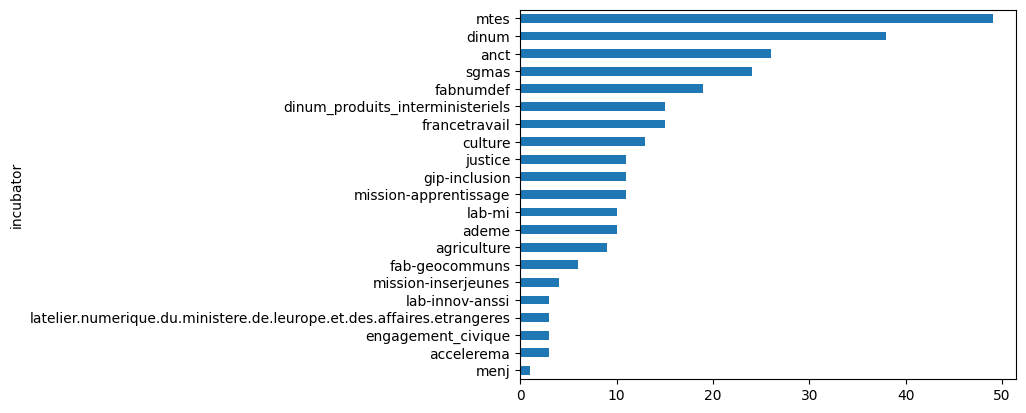

In [26]:
display_markdown(
    "## Startups par incubateur (hors alumni)",
    raw=True,
)
startups_df.query("phase != 'alumni'").groupby(
    "incubator", dropna=False
).size().sort_values().plot(
    kind="barh",
);


## Startups par thématiques

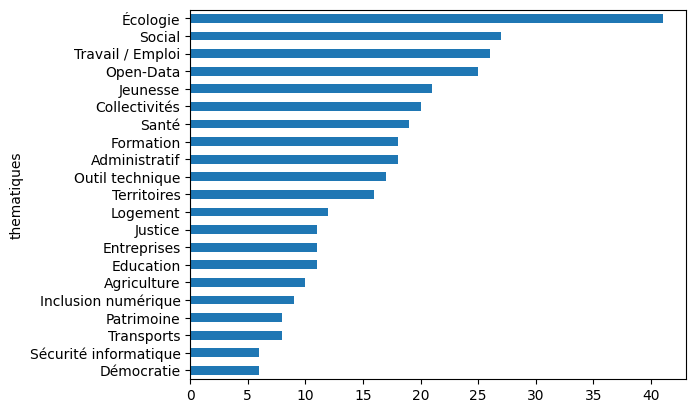

In [27]:
display_markdown(
    "## Startups par thématiques",
    raw=True,
)
startups_df_exploded = startups_df.explode("thematiques")
thematiques_count = startups_df_exploded.groupby(["thematiques"]).size()
thematiques_count_filtered = thematiques_count[thematiques_count > 5]
thematiques_count_sorted = thematiques_count_filtered.sort_values()
thematiques_count_sorted.plot(kind="barh");

## Startups par sponsor

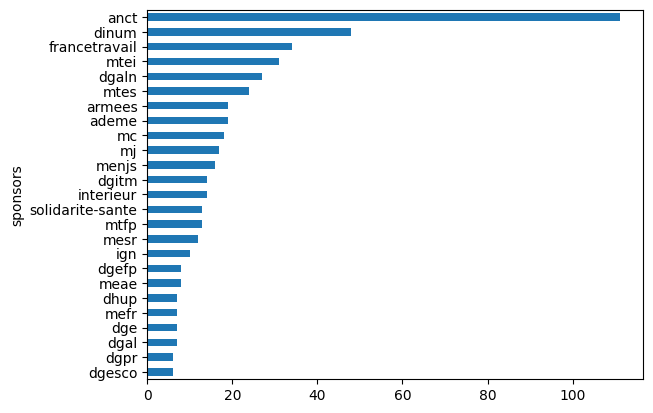

In [28]:
display_markdown(
    "## Startups par sponsor",
    raw=True,
)
startups_df_exploded = startups_df.explode("sponsors")
sponsors_count = startups_df_exploded.groupby(["sponsors"]).size()
sponsors_count_filtered = sponsors_count[sponsors_count > 5]
sponsors_count_sorted = sponsors_count_filtered.sort_values()
sponsors_count_sorted.plot(kind="barh");

## Startups par sponsor (hors alumni)

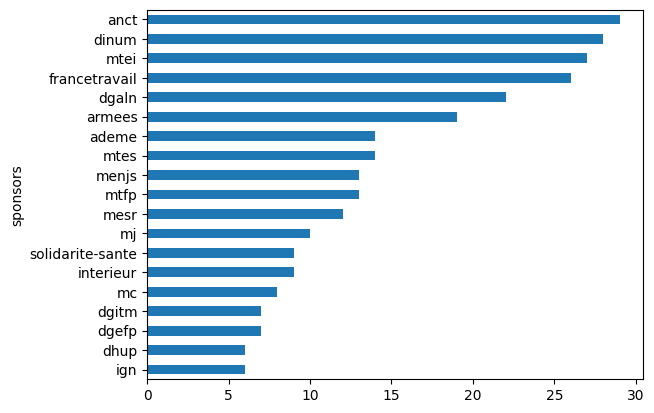

In [29]:
display_markdown(
    "## Startups par sponsor (hors alumni)",
    raw=True,
)
startups_df_exploded = startups_df.query("phase != 'alumni'").explode("sponsors")
sponsors_count = startups_df_exploded.groupby(["sponsors"]).size()
sponsors_count_filtered = sponsors_count[sponsors_count > 5]
sponsors_count_sorted = sponsors_count_filtered.sort_values()
sponsors_count_sorted.plot(kind="barh");

## Startups par incubateur et par phase (hors alumni)

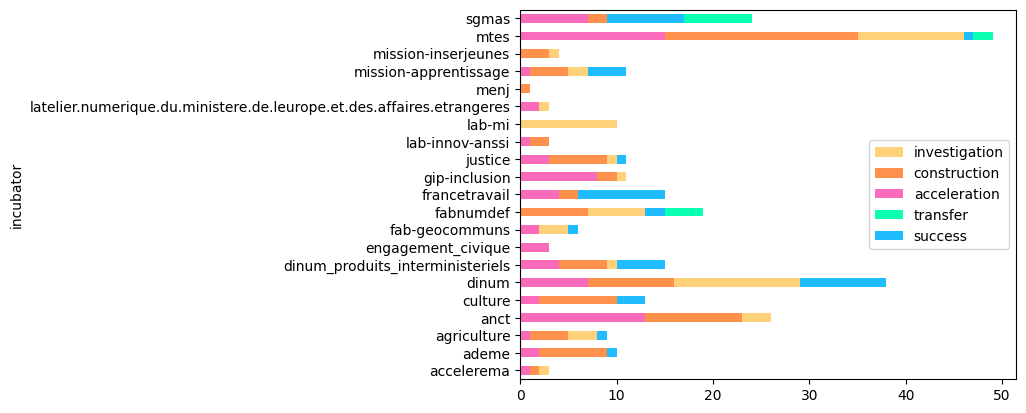

In [30]:
display_markdown(
    "## Startups par incubateur et par phase (hors alumni)",
    raw=True,
)
startups_df.query("phase != 'alumni'").groupby(
    ["incubator", "phase"], dropna=False
).size().sort_values(ascending=False).unstack(fill_value=0).plot(
    kind="barh",
    stacked=True,
)

# fix legend
handles, labels = pyplot.gca().get_legend_handles_labels()
sorted_order = [phases.index(x) for (i, x) in enumerate(labels)]
for i, handle in enumerate(handles):
    for bar in handle:
        color = colors[sorted_order[i]]
        bar.set_facecolor(color)
sorted_handles = [x for _, x in sorted(zip(sorted_order, handles))]
pyplot.legend(
    sorted_handles,
    sorted(labels, key=lambda x: phases.index(x)),
);

## Startups par thématique et par phase (hors alumni)

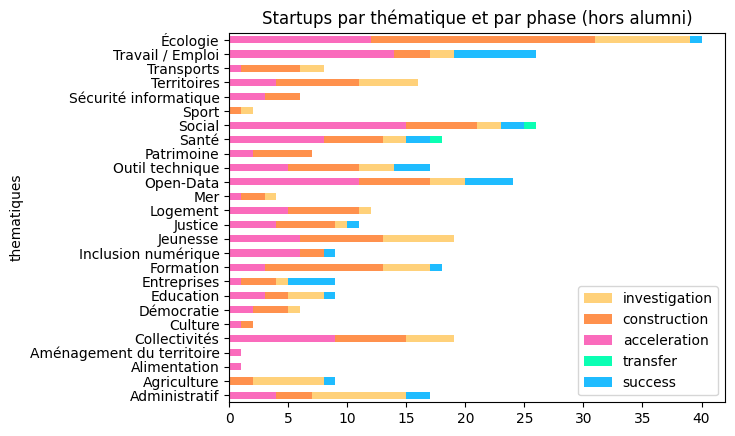

In [31]:
display_markdown(
    "## Startups par thématique et par phase (hors alumni)",
    raw=True,
)
startups_df_exploded = startups_df.query("phase != 'alumni'").explode("thematiques")
startups_df_exploded.groupby(["thematiques", "phase"]).size().unstack(
    fill_value=0
).plot(kind="barh", stacked=True)

# fix legend
handles, labels = pyplot.gca().get_legend_handles_labels()
sorted_order = [phases.index(x) for (i, x) in enumerate(labels)]
for i, handle in enumerate(handles):
    for bar in handle:
        color = colors[sorted_order[i]]
        bar.set_facecolor(color)
sorted_handles = [x for _, x in sorted(zip(sorted_order, handles))]
pyplot.legend(
    sorted_handles,
    sorted(labels, key=lambda x: phases.index(x)),
)

pyplot.title("Startups par thématique et par phase (hors alumni)");

In [32]:
display_markdown("## SE en accélération sans stats_url",
    raw=True,
)
startups_df.query("phase == 'acceleration' and stats_url!=stats_url")[
    ["id", "incubator", "phase", "stats_url"]
]

## SE en accélération sans stats_url

,id,incubator,phase,stats_url


In [33]:
display_markdown(
    "## SE en accélération sans dashlord_url",
    raw=True,
)
startups_df.query("phase == 'acceleration' and dashlord_url!=dashlord_url")[
    ["id", "incubator", "phase", "dashlord_url"]
]

## SE en accélération sans dashlord_url

,id,incubator,phase,dashlord_url
73,api-engagement,engagement_civique,acceleration,NaN
81,aplus,anct,acceleration,NaN
92,audioconf,dinum_produits_interministeriels,acceleration,NaN
103,bases.adresses.locales,anct,acceleration,NaN
115,bpco,sgmas,acceleration,NaN
133,chauffage-urbain,mtes,acceleration,NaN
142,collectif_objets,culture,acceleration,NaN
161,data.etat,dinum,acceleration,NaN
211,estime.formation,francetravail,acceleration,NaN
220,expresso,latelier.numerique.du.ministere.de.leurope.et.des.affaires.etrangeres,acceleration,NaN


In [34]:
display_markdown(
    "## SE sans stats_url",
    raw=True,
)
startups_df.query("phase != 'alumni' and stats_url == ''")[
    ["id", "incubator", "phase", "stats_url"]
]

## SE sans stats_url

,id,incubator,phase,stats_url
0,1-jeune-1-arbre,agriculture,investigation,
7,accesscite,mtes,construction,
11,agora,dinum,construction,
16,aigle,mtes,construction,
17,airvam,fabnumdef,construction,
...,...,...,...,...
500,urgencevie,lab-mi,investigation,
504,vapp,mtes,investigation,
506,vert.impact,mtes,investigation,
507,vie.chere,lab-mi,investigation,


## Membres

In [35]:
authors_df = pandas.DataFrame.from_dict(authors)

display_markdown(
    "## Aperçu des données (membres)",
    raw=True,
)

authors_df.head(10)

## Aperçu des données (membres)

,id,fullname,role,domaine,link,bio,missions,competences,github,startups,previously
0,abdelaziz.adara,Abdelaziz Adara,ADV,Autre,,,"[{'start': '2024-05-22', 'end': '2024-12-31', 'status': 'independent', 'employer': 'Malt'}]",[Communication],NaN,NaN,NaN
1,abdelaziz.sakhi,Abdelaziz Sakhi,Développeur,Développement,,,"[{'start': '2022-07-08', 'end': '2024-12-31', 'status': 'independent', 'employer': 'Malt', 'startups': ['infrastructures.numeriques']}]",NaN,abdelazizsakhi,[infrastructures.numeriques],NaN
2,abdellah.benhallou,Abdellah Ben Hallou,Chargé de déploiement,Déploiement,,,"[{'start': '2020-10-01', 'end': '2021-02-19', 'status': 'independent', 'employer': ''}]",NaN,abdellahbh,NaN,"[aplus, workinfrance]"
3,abdellah.bouhend,Abdellah Bouhend,Chargé de déploiement,Déploiement,,Chargé de déploiement / Haut-Savoyard / Trail runner dilettante,"[{'start': '2022-02-01', 'end': '2024-06-29', 'status': 'independent', 'employer': '', 'startups': ['la-bonne-alternance']}]",NaN,Waltenberg03,[la-bonne-alternance],NaN
4,abdessamad.youssfi,Abdessamad Youssfi,Gestionnaire de produit,Déploiement,,,"[{'start': '2019-10-14', 'end': '2022-09-30', 'status': 'independent', 'employer': 'Octo'}, {'start': '2022-10-01', 'end': '2025-10-05', 'status': 'admin', 'employer': 'GIP Plateforme de l'inclusion'}]","[Croissance, Gestion de Produit]",Abdessamadyssf,[place-de-marche-inclusion],"[codedutravail, les-emplois]"
5,abel.andre,Abel André,Développeur,Développement,,,"[{'start': '2018-07-16', 'end': '2019-06-30', 'status': 'service', 'employer': 'octo', 'startups': ['pass-culture']}]",NaN,abel-andre,[pass-culture],NaN
6,adele.de.pimodan,Adèle de Pimodan,Responsable RH,Animation,,RH,"[{'start': '2023-06-18', 'end': '2026-07-03', 'status': 'admin', 'employer': 'GIP Inclusion'}]",NaN,NaN,NaN,NaN
7,adele.schlauder,Adèle Schlauder,Intrapreneur,Intraprenariat,,,"[{'start': '2021-09-13', 'end': '2023-09-13', 'status': 'admin', 'employer': 'Ministère de l'Intérieur', 'startups': ['dialogue.operationnel']}]",[Administration Publique],NaN,[dialogue.operationnel],NaN
8,adeline.brogard,Adeline brogard,ux designer,Design,,Je suis actuellement UX designer sur la startup Mobiville de Pole emploi. Je co-anime la communauté ux de l’incubateur avec Adrien,"[{'start': '2020-03-06', 'end': '2021-12-31', 'status': 'service', 'employer': 'INOPS'}]",NaN,NaN,NaN,NaN
9,adeline.celier,Adeline Celier,Designer de service,Design,,Designer de service pour les merlus et les grondins.,"[{'start': '2022-01-01', 'end': '2024-12-31', 'status': 'independent', 'employer': 'Malt', 'startups': ['monitorfish']}]",NaN,AdelineCelier,[monitorfish],NaN


## Compétences de la communauté

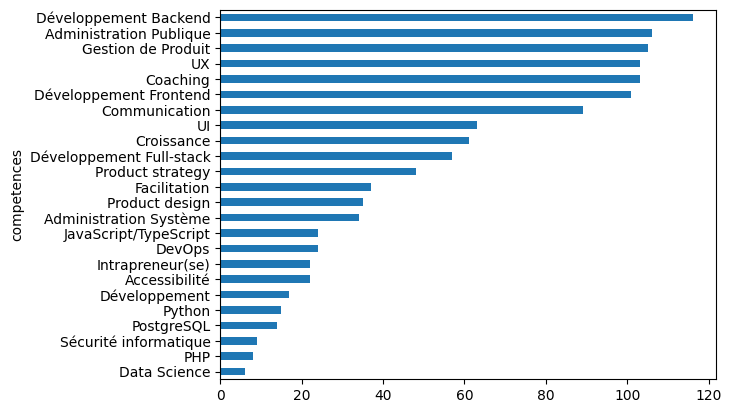

In [36]:
display_markdown(
    "## Compétences de la communauté",
    raw=True,
)
authors_df_exploded = authors_df.explode("competences")
competences_count = authors_df_exploded.groupby(["competences"]).size()
competences_count_filtered = competences_count[competences_count > 5]
competences_count_sorted = competences_count_filtered.sort_values()
competences_count_sorted.plot(kind="barh");

## Domaines de la communauté

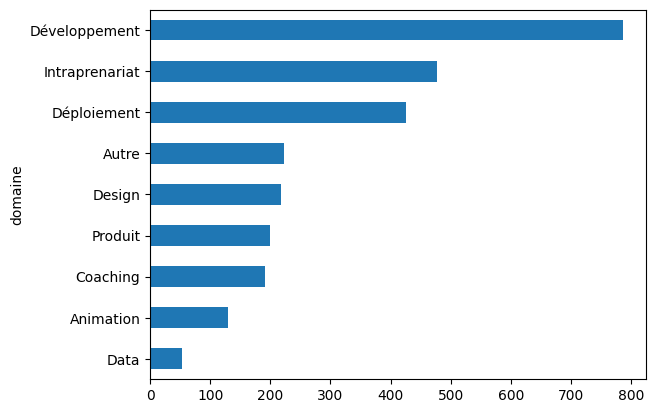

In [37]:
display_markdown(
    "## Domaines de la communauté",
    raw=True,
)
domaine_count = authors_df.groupby(["domaine"]).size()
domaine_count_sorted = domaine_count.sort_values()
domaine_count_sorted.plot(kind="barh");

In [178]:
display_markdown(
    "## Coaches par startup",
    raw=True,
)
df2 = authors_df.query("domaine == 'Coaching'")[["id", "missions"]]

def extract_se(x):
    ses = [m.get("startups", []) for m in x if m and datetime.fromisoformat(m.get("start")) <= datetime.now() and (not m.get("end") or datetime.fromisoformat(m.get("end")) > datetime.now()) ]
    return ses and ses[0] or []

df2["startups"] = df2["missions"].apply(lambda x: flatmap(extract_se(x)))
df2.explode("startups").groupby(["startups"]).agg({'id': lambda x: ", ".join(x)})


## Coaches par startup

,id
startups,
a-just,paul.marcade
acceslibre,jules.delmas
accesscite,"kevin.tan, melanie.briand"
aides-territoires,john.labuzan
aigle,thibault.tezier
...,...
urgencevie,frederic.dol
versementgetorix,laure.de-valon
vigieau,astrid.tarteret
